# How to select an objective function using information theory

 [![GitHub tag (latest by date)](https://img.shields.io/github/v/tag/hytest-org/workflow-hodson-2022-objective-benchmark)](https://github.com)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hytest-org/workflow-hodson-2022-objective-benchmark/blob/main/01-objective-benchmark-demo.ipynb)

## Abstract
Science tests competing theories or models by evaluating the similarity of their predictions against observational experience. 
Thus, how we measure similarity fundamentally determines what we learn.
In machine learning and scientific modeling, similarity metrics are used as objective functions.
A classic example being mean squared error, which is the optimal measure of similarity when errors are normally distributed and independent and identically distributed (iid). 
In many cases, however, the error distribution is neither normal nor iid, so it is left to the scientist to determine an appropriate objective.
Here, we review how information theory can guide that selection, then demonstrate the approach with a simple hydrologic model.

## Introduction
Science seeks to create useful representations of reality in the form of hypotheses, models, or theories.
What sets science apart from other pursuits is that it rigorously tests those representations against observational experience,
favoring those that best fit the evidence.
An analogous process occurs when calibrating a numerical model or evaluating among competing models.
To select the ``best'' model, experiment by varying the model while keeping the test data and objective fixed.
If mean squared error (MSE) is the objective, compute the MSE between the test data and the model predictions, then select the model with the lowest MSE.
But why choose MSE and not another objective function?
The answer: MSE is the optimal measure when errors are normally distributed and iid.
But for many problems, the true error distribution is complex or unknown.
Rather than simply assuming some de facto objective function, 
compare them against the evidence.
This paper demonstrates how.

To select the best objective, the experiment is essentially the same except the objective is varied while the model and data are held fixed.
Now, select the objective indicating the greatest similarity between data and model.
Different objective functions have different scales, so they are normalized
such that each integrates to one, thereby representing them as probability distributions.
The normalized form of MSE is the normal distribution, for example (Hodson, 2022).
When used to evaluate model fit, the probability distribution is called a likelihood function
and its output the likelihood.
So, to select among objectives, compare their likelihoods, and favor the most likely.
Taking the natural logarithm of the likelihood, denoted as $\ell$,
does not change the models ranks
but simplifies the math by converting products to sums:
likelihoods multiply, so log likelihoods add.


So, to benchmark objectives, compare their log likelihoods.
The maximum likelihood estimators for the log likelihoods of several objectives are implemented below.

In [7]:
# compute likelihood
import numpy as np
from scipy.stats import pearsonr
import scipy.stats


def normal_ll(y, y_hat, transform=None, gradient=1):
    '''Log likelihood for the normal distribution with change of variable
    
    The normal distribution is the formal likelihood for the mean squared error (MSE).
    

    Parameters
    ----------
    y : array_like
        Observations.
    y_hat : array_like
        Predictions.
    transform : function
        Change of variable transformation.
    gradient : function
        Gradient of the transform function.
        
    Proof
    -----
    https://www.statlect.com/probability-distributions/normal-distribution
    '''
    if transform is not None:
        y = transform(y)
        y_hat = transform(y_hat)
        
    e = y - y_hat
    n = len(e)
    sigma = e.std()
    log_gradient = np.sum(np.log(np.abs(gradient)))
    ll = -n * np.log(sigma) - n/2*np.log(2*np.pi) - 1/(2*sigma**2) * (e**2).sum() + log_gradient
    return ll


def laplace_ll(y, y_hat, transform=None, gradient=1):
    '''Log likelihood for Laplace distribution with change of variable
    
    The laplace distribution is the formal likelihood for the mean absolute
    error (MAE).
    
    Parameters
    ----------
    y : array_like
        Observations.
    y_hat : array_like
        Predictions.
    transform : function
        Change of variable transformation.
    gradient : function
        Gradient of the transform function.
    '''
    if transform is not None:
        y = transform(y)
        y_hat = transform(y_hat)
        
    e = (y - y_hat).abs()
    n = len(e)
    b = e.mean()
    log_gradient = np.sum(np.log(np.abs(gradient)))
    ll = -n * np.log(2*b) - 1/b * e.sum() + log_gradient
    return ll.sum()
                                   

def msre_ll(y, y_hat):
    '''Log likelihood for mean squared square-root error
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    return normal_ll(y, y_hat, transform=lambda x: np.sqrt(x), gradient=-1/(2*np.sqrt(y)))


def mare_ll(y, y_hat):
    '''Log likelihood for mean absolute square-root error
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    return laplace_ll(y, y_hat, transform=lambda x: np.sqrt(x), gradient=-1/(2*np.sqrt(y)))


def lognormal_ll(y, y_hat):
    '''Lognormal log likelihood
    
    The lognormal distribution is the formal likelihood for the mean squared
    log error (MSLE).
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    return normal_ll(y, y_hat, transform=lambda x: np.log(x), gradient=1/y)


def mspe_ll(y, y_hat):
    '''Log likelhood for mean squared percentage error
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    
    '''
    return normal_ll(y, y_hat, transform=lambda x: x/y, gradient=-1/(y**2)) 


def nse_ll(y, y_hat, group='gage_id'):
    '''Log likelihood for normalized squared error (NSE)
    
    NSE is equivalent to the Nash–Sutcliffe model efficiency coefficient.
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    sigma_o = y.groupby('gage_id').transform(lambda x: x.std())
    return normal_ll(y, y_hat, transform=lambda x: x/sigma_o, gradient=1/sigma_o)


def loglaplace_ll(y, y_hat):
    '''Log likelihood for log Laplace distribution
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    return laplace_ll(y, y_hat, transform=lambda x: np.log(x), gradient=1/y)


def uniform_ll(y, y_hat):
    '''Log likelihood for uniform distribution.
    
    The uniform log likelihood minimizes the maximum error.
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    e = np.abs(y - y_hat)
    n = len(e)
    #ll = -n * np.log(e.max()-e.min()) # standard formulation
    ll = -n * np.log(e.max() - 0)
    return ll


def bernoulli_ll(y, y_hat, groupby=None):
    '''TODO and use within zi_ll
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    pass



def zi_ll(y, y_hat, ll=normal_ll, threshold=0.01, groupby=None):
    ''' Zero-inflated log likelihood.
    
     Parameters
    ----------
    y : array_like
    y_hat : array_like
    ll : function
        Zero-inflated log likelihood 
    threshold : float
        Value below which is treated as zero
    groupby : string
        Optional groupby term (testing)
    '''
    y_o = y <= threshold
    y_hat_o = y_hat <= threshold
    
    if groupby is None:
        n1 = (y_o & y_hat_o).sum() # correct zero-flow prediction
        n2 = (y_o ^ y_hat_o).sum() # incorrect zero-flow prediction 
    else:
        n1 = (y_o & y_hat_o).groupby(groupby).sum() # correct zero-flow prediction
        n2 = (y_o ^ y_hat_o).groupby(groupby).sum() # incorrect zero-flow prediction

    n3 = (~y_o & ~y_hat_o) # correct flow predictions
    
    # fraction of correctly predicted zero flows
    rho = np.where( (n1+n2) == 0, 0, n1 / (n1 + n2))
    n_rho = 1-rho
    
    # n1 * np.log(rho) + n2 * np.log(1-rho)
    ll_zero = n1[rho!=0] * np.log(rho[rho!=0]) + n2[n_rho!=0]* np.log(n_rho[n_rho!=0])
    
    return ll_zero.sum() + ll(y[n3], y_hat[n3])


def zilognormal_ll(y, y_hat):
    '''Log likelihood for zero-inflated lognormal.
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
       
    return zi_ll(y, y_hat, ll=lognormal_ll, threshold=0.01)


def ziloglaplace_ll(y, y_hat):
    '''Log likelihood for zero-inflated laplace.
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    return zi_ll(y, y_hat, ll=loglaplace_ll, threshold=0.01)


In [8]:
import pandas as pd
import numpy as np

# read local copy
df = pd.read_parquet('gages2_nndar.parquet')
df[df < 0.01] = 0.01

sigma_o = df['obs'].groupby('gage_id').transform(lambda x: x.std())

In [10]:
count = df.groupby('gage_id').count()['obs']

In [11]:
# step 1: create a table of objective functions
objectives = {
    'U' : {'name':'uniformly distributed error', 'f':uniform_ll},
    'MSE' : {'name':'mean squared error', 'f':normal_ll},
    'NSE' : {'name':'normalized squared error', 'f':nse_ll},
    'MAE' : {'name': 'mean absolute error', 'f':laplace_ll},
    'MSPE' : {'name': 'mean squared percent error', 'f':mspe_ll},
    'MSLE' : {'name':'mean squared log error*', 'f':lognormal_ll},
    'MALE' : {'name':'mean absolute log error*', 'f':loglaplace_ll},
    'ZMSLE' : {'name':'zero-inflated MSLE', 'f':zilognormal_ll},
    'ZMALE' : {'name':'zero-inflated MALE', 'f':ziloglaplace_ll},
    'MARE' : {'name':'mean absolute square root error', 'f':mare_ll},
}

obj_df = pd.DataFrame.from_dict(objectives, orient='index')

# step 2: compute the information in each objective function
results = []
for index, row in obj_df.iterrows():
    # nats is the negative log likelihood or the info in the error
    #results.append(- row.f(df.obs, df.NNDAR)/count/np.log(2) )
    results.append(- df.groupby('gage_id').apply(lambda x: row.f(x['obs'], x['NNDAR']))/count/np.log(2))

/tmp/ipykernel_88/340847794.py:198: RuntimeWarning: invalid value encountered in scalar divide
  rho = np.where( (n1+n2) == 0, 0, n1 / (n1 + n2))
/tmp/ipykernel_88/340847794.py:198: RuntimeWarning: invalid value encountered in scalar divide
  rho = np.where( (n1+n2) == 0, 0, n1 / (n1 + n2))


In [20]:
columns = ['MSPE','U','MSE','NSE','MAE', 'MSLE','MARE','ZMSLE','MALE','ZMALE']

In [21]:
results_df = pd.DataFrame({c: i for i,c in zip(results,columns)})

In [22]:
results_df[results_df > 200] = np.nan # nan any crazy values

In [60]:
import matplotlib.pyplot as plt
sns.set_theme(style="white")
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

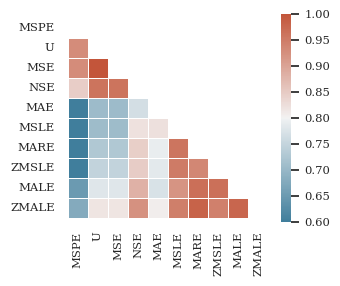

In [61]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = results_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(5.512, 5))
f, ax = plt.subplots(figsize=(3.54, 3))
# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0.6,
            square=True, linewidths=0.5, cbar_kws={"shrink": 1})

f.tight_layout()
f.savefig('figure2.pdf')